In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measure = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB

sess = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
sess.query(Measure).first().__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x143488150>,
 'tobs': 65.0,
 'id': 1,
 'station': 'USC00519397',
 'date': '2010-01-01',
 'prcp': 0.08}

In [10]:
sess.query(Station).first().__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x120e31810>,
 'latitude': 21.2716,
 'id': 1,
 'elevation': 3.0,
 'station': 'USC00519397',
 'name': 'WAIKIKI 717.2, HI US',
 'longitude': -157.8168}

In [17]:
# Find the most recent date in the data set.
date_latest = sess.query(Measure.date).order_by(Measure.date.desc()).first()
date_latest
# Since the dates are ordered YYYY-MM-DD, it does not matter whether or not we convert it to datetime.
# Definitely want to watch out for potential issues on other date formats, though.

('2017-08-23',)

In [24]:
type(date_latest)

datetime.datetime

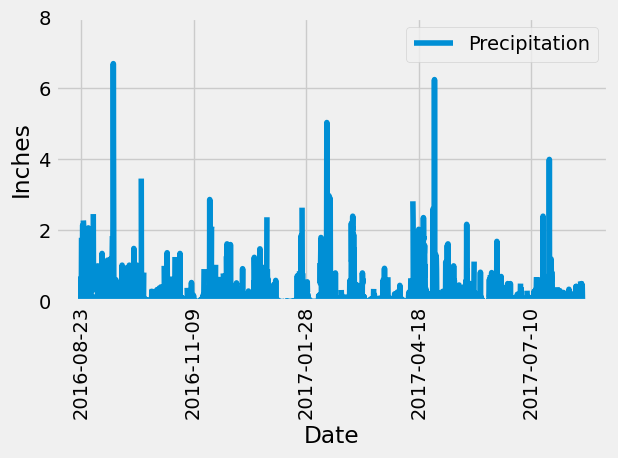

In [97]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database.
from dateutil.relativedelta import relativedelta

# Calculate the date one year from the last date in data set.
# I'm not sure if adding the extra 1 day is correct, but it made my output match the provided sample output in the .describe() cell below
date_1yr_back = date_latest - relativedelta(months=12, days=1)

# Perform a query to retrieve the data and precipitation scores
# TODO: CONFIRM THAT THIS QUERY IS OK, GIVEN THAT IT PASSES A DATE VARIABLE INTO THE QUERY
prcp_past_1yr = sess.query(Measure.date, Measure.prcp).filter(Measure.date >= date_1yr_back).order_by(Measure.date.desc())

# Save the query results as a Pandas DataFrame. Explicitly set the column names
# Sort the dataframe by date
df_prcp_1yr = pd.DataFrame(prcp_past_1yr).rename(columns={'date': 'Date', 'prcp': 'Precipitation'}).set_index('Date').sort_index(ascending=True)

df_prcp_1yr.head()

# Use Pandas Plotting with Matplotlib to plot the data

df_prcp_1yr.plot(kind='line', ylim=[0, 8])
plt.ylabel("Inches")
plt.xlabel("Date")
plt.xticks(rotation=90)
plt.legend(loc='upper right')
plt.tight_layout()

plt.show()

# I could mess with the xticks but I'm gonna call this good enough.

In [57]:
# Use Pandas to calculate the summary statistics for the precipitation data
df_prcp_1yr.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [61]:
# Design a query to calculate the total number of stations in the dataset
sess.query(Station.station).count()


9

In [62]:
sess.query(Measure).group_by(Measure.station).count()

9

In [79]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
station_activity = sess.query(Measure.station, func.count(Measure.station)).group_by(Measure.station).order_by(func.count(Measure.station).desc()).all()
station_activity

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [93]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
sess.query(func.min(Measure.tobs), func.max(Measure.tobs), func.avg(Measure.tobs)).filter(Measure.station == station_activity[0][0]).order_by(None).all()

[(54.0, 85.0, 71.66378066378067)]

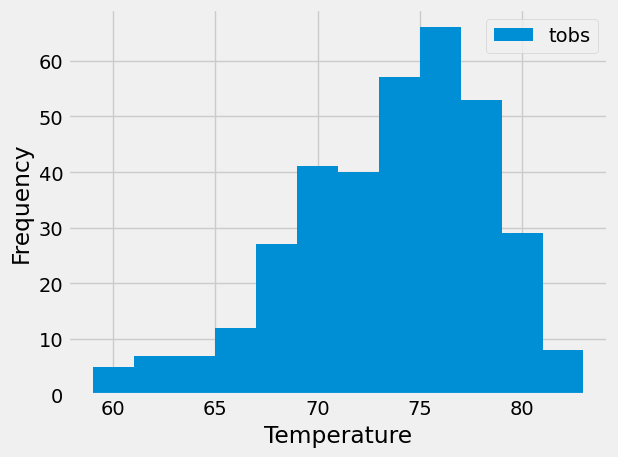

In [98]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tobs_past_1yr = sess.query(Measure.date, Measure.tobs).filter(Measure.date >= date_1yr_back, Measure.station == station_activity[0][0]).order_by(Measure.date)

# Use Pandas Plotting with Matplotlib to plot the data
df_tobs_1yr = pd.DataFrame(tobs_past_1yr).sort_values('tobs', ascending=True)

df_tobs_1yr.head()

df_tobs_1yr['tobs'].plot(kind='hist', bins=12)
plt.ylabel("Frequency")
plt.xlabel("Temperature")
plt.legend(loc='upper right')
plt.tight_layout()

plt.show()

# Close Session

In [16]:
# Close Session
session.close()